## Optional: Installationen

In [1]:
!pip install numpy

In [2]:
!pip install scipy

In [3]:
 !pip install matplotlib

In [4]:
!pip install pandas

In [5]:
!pip install torch

In [6]:
!pip install torchvision

# KI-gestützte Bilderkennung zur automatisierten Müllklassifizierung und Trennhilfe

**Modul:** Selected Topics of AI <br>
**Bearbeitet von:** Lars Gerigk (lg107), Julia Ebert (je073), Joel Starkov (js486) <br>
**Abgabe:** 28.01.2026 <br>

### Motivation 
Viele trennen den Müll nicht richtig, Gründe: sie kennen es nicht, in anderen Ländern gibt es keine Mülltrennung, viele Menschen verstehen den unterschied aber auch  nicht

### Ziel 
Daher Lösung: Mülleimer der Müll Scannt und dir visuell zeigt in welchen Mülleimer der Müll kommt

### Müllklassifikation 
Wir wollen die Mülltrennung mit dem Fokus auf die Hochschule der Medien (kurz: HdM) verbesssern. Daher beziehen wir uns bei der Klassifikation auf die Klassen "Pfand", "Restmüll", "Papier", "Verpackungen" und "Sonstiges" <br><br>

**Pfand:** <br>
**Restmüll:** <br>
**Papier:** <br>
**Verpackungen:** <br>
**Sonstiges:** Für diese Kategorie sind alle Objekte vorgesehen, die in keiner der oben genannten Kategorien zugeordnet werden und nicht in den HdM-Müll entsorgt werden dürfen. Zum Beispiel: Batterien; Bilder von Personen, die sich z.B.: vor der Kamera befinden <br><br>


Daten 
-> sollten nicht optimal sein <br>
-> verschiedene Lichtverhältnisse, Hände im Bild, Graustufenbild vs Farbbild, 




### Import von Abhängigkeiten

In [7]:
import os
import numpy as np
import scipy.io as io
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torchvision
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import random_split, DataLoader

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


### Datensetanalyse

Für die Daten haben wir uns dafür entschieden ein Datenset von Kaggle zu verwenden hier die Daten von dem Datenset "Garbage Classification" von Mostafa Mohamed. Dieses ist unter dem folgenden Link zu finden: https://www.kaggle.com/datasets/mostafaabla/garbage-classification, entnommen am 23.12.2025. Um mit den Datensats besser verwenden zu können haben wir die Bilder manuell in unsere oben genannten Kategorien eingeteilt. 

Zudem haben wir eigene Bilder gesammelt, die man dem Ordner xy entnehmen kann. 

Weights and Bias

### Datenaufbereitung

Alle Bilder in eine Größe bringen <br>
Drehen und verzerren etc. 
Ohne Farben arbeiten? 

In [10]:
dataDir = "./Train-Data"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

full_dataset = datasets.ImageFolder(
    root=dataDir,
    transform=transform
)

##### Automatische Aufteilung zwischen Trainings- und Testdaten 

In [11]:
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

generator = torch.Generator().manual_seed(42)

train_dataset, test_dataset = random_split(
    full_dataset,
    [train_size, test_size],
    generator=generator
)

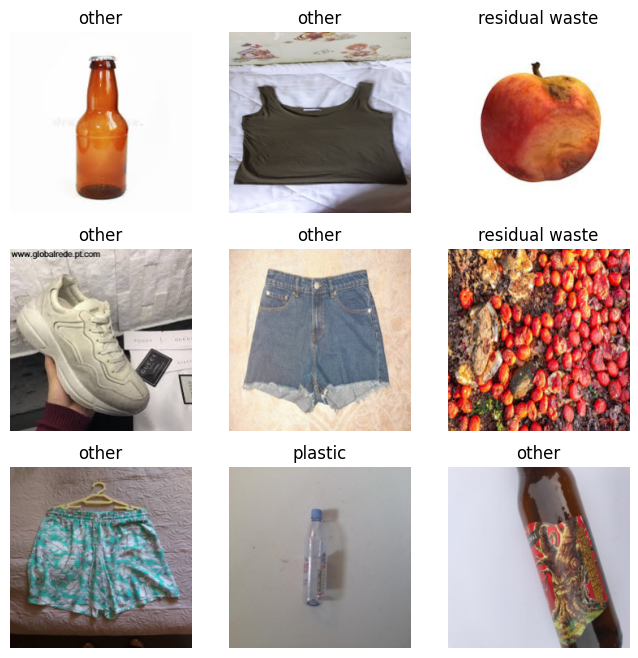

In [18]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
class_names = full_dataset.classes  # <- Klassenlabels

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    img = img.permute(1, 2, 0)
    class_name = class_names[label]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.title(class_name)
    plt.imshow(img)
plt.show()

##### Dataloader erstellen

In [14]:
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False
)